# Convolutional Neural Net for Food Classification

In [1]:
from collections import Counter

import h5py
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
%matplotlib inline

In [5]:
base_path = os.path.join('.')
train_h5_path = os.path.join(base_path, 'food_c101_n10099_r64x64x3.h5')
test_h5_path = os.path.join(base_path, 'food_test_c101_n1000_r64x64x3.h5')
print(train_h5_path)
print(test_h5_path)

.\food_c101_n10099_r64x64x3.h5
.\food_test_c101_n1000_r64x64x3.h5


In [6]:
f_train = h5py.File(train_h5_path, 'r')
print(list(f_train.keys()))
f_test = h5py.File(test_h5_path, 'r')
print(list(f_test.keys()))

['category', 'category_names', 'images']
['category', 'category_names', 'images']


In [7]:
X = np.array(f_train.get('images'))
y = np.array(f_train.get('category'))
y_labels = np.array([raw_category.decode() for raw_category in f_train.get('category_names')])
X_test = np.array(f_test.get('images'))
y_test = np.array(f_test.get('category'))
y_test_labels = np.array([raw_category.decode() for raw_category in f_test.get('category_names')])
print('Train/dev shapes. X: {0} y: {1}'.format(X.shape, y.shape))
print('Test shapes. X: {0} y: {1}'.format(X_test.shape, y_test.shape))
print(np.unique(y_labels))

Train/dev shapes. X: (10099, 64, 64, 3) y: (10099, 101)
Test shapes. X: (1000, 64, 64, 3) y: (1000, 101)
['apple_pie' 'baby_back_ribs' 'baklava' 'beef_carpaccio' 'beef_tartare'
 'beet_salad' 'beignets' 'bibimbap' 'bread_pudding' 'breakfast_burrito'
 'bruschetta' 'caesar_salad' 'cannoli' 'caprese_salad' 'carrot_cake'
 'ceviche' 'cheese_plate' 'cheesecake' 'chicken_curry'
 'chicken_quesadilla' 'chicken_wings' 'chocolate_cake' 'chocolate_mousse'
 'churros' 'clam_chowder' 'club_sandwich' 'crab_cakes' 'creme_brulee'
 'croque_madame' 'cup_cakes' 'deviled_eggs' 'donuts' 'dumplings' 'edamame'
 'eggs_benedict' 'escargots' 'falafel' 'filet_mignon' 'fish_and_chips'
 'foie_gras' 'french_fries' 'french_onion_soup' 'french_toast'
 'fried_calamari' 'fried_rice' 'frozen_yogurt' 'garlic_bread' 'gnocchi'
 'greek_salad' 'grilled_cheese_sandwich' 'grilled_salmon' 'guacamole'
 'gyoza' 'hamburger' 'hot_and_sour_soup' 'hot_dog' 'huevos_rancheros'
 'hummus' 'ice_cream' 'lasagna' 'lobster_bisque' 'lobster_roll

## Images Vizualization

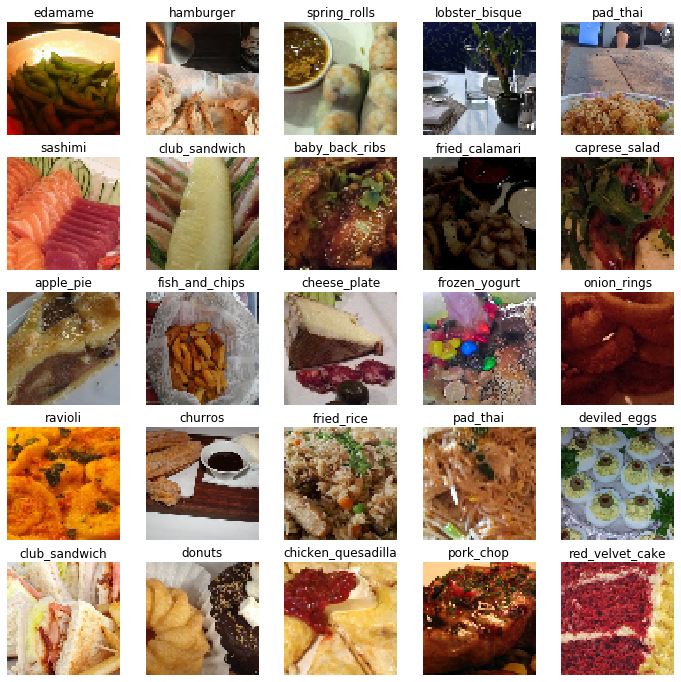

In [8]:
sample_images = 25
total_images = X.shape[0]
read_idxs = slice(0,sample_images)
image_data = X[read_idxs]
image_label = y[read_idxs]
fig, m_ax = plt.subplots(5, 5, figsize = (12, 12))
for c_ax, c_label, c_img in zip(m_ax.flatten(), image_label, image_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title(y_labels[np.argmax(c_label)])

The dataset have 101 different foods, so to plot isn't intersting. I want to know if the quantity of the different classes is similar.

In [9]:
quantities = dict(sorted(Counter([y_labels[i][0] for i in y]).items(), key=lambda kv: kv[1]))

In [10]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2)

In [11]:
batch_size = 128
epochs = 32

In [12]:
train_image_generator = ImageDataGenerator(rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)
# Generator for our training data
dev_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [13]:
train_data_gen = train_image_generator.fit(X_train)
dev_data_gen = dev_image_generator.fit(X_dev)

In [14]:
print(X_train.shape[1:])
print(y_train.shape[1])

(64, 64, 3)
101


In [15]:
model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [16]:
history = model.fit_generator(
    train_image_generator.flow(X_train,y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=dev_image_generator.flow(X_dev, y_dev, batch_size=batch_size),
    validation_steps=X_dev.shape[0] // batch_size
)


Epoch 1/32
63/63 [==============================] - 28s 441ms/step - loss: 4.6093 - accuracy: 0.0111 - val_loss: 4.5934 - val_accuracy: 0.0219
Epoch 2/32
63/63 [==============================] - 29s 461ms/step - loss: 4.5709 - accuracy: 0.0164 - val_loss: 4.5589 - val_accuracy: 0.0229
Epoch 3/32
63/63 [==============================] - 28s 437ms/step - loss: 4.5320 - accuracy: 0.0210 - val_loss: 4.5379 - val_accuracy: 0.0271
Epoch 4/32
63/63 [==============================] - 27s 435ms/step - loss: 4.5191 - accuracy: 0.0197 - val_loss: 4.5345 - val_accuracy: 0.0208
Epoch 5/32
63/63 [==============================] - 27s 434ms/step - loss: 4.4825 - accuracy: 0.0280 - val_loss: 4.4905 - val_accuracy: 0.0307
Epoch 6/32
63/63 [==============================] - 27s 434ms/step - loss: 4.4204 - accuracy: 0.0314 - val_loss: 4.4247 - val_accuracy: 0.0292
Epoch 7/32
63/63 [==============================] - 28s 441ms/step - loss: 4.3934 - accuracy: 0.0337 - val_loss: 4.4046 - val_accuracy: 0.0292

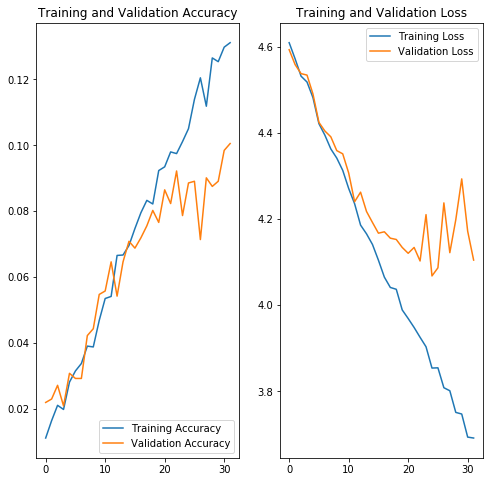

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()